# Evaluating and Tuning a Binary Classification Model

## Goals

After this lesson, you should be able to:

- Build and explain confusion matrices from a model output
- Calculate various binary classification metrics
- Explain the AUC/ROC curve, why it matters, and how to use it
- Understand when and how to optimize a model for various metrics
- Optimize a classification model based on costs

### Category definitions - possible outcomes in binary classification
 
#### - TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
#### - TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
#### - FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
#### - FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

### $$ \text{Possible misclassifications} $$

![Type 1 vs. Type 2 Error](images/type-1-type-2.jpg)

## Let's run a model and look at some metrics 

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('./data/heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df['target'].value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

In [6]:
X = df.drop('target', axis = 1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 77, stratify = y, test_size = .5)

In [7]:
y_train.mean(), y_test.mean()

(0.543046357615894, 0.5460526315789473)

In [8]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 77)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=77, verbose=0,
                       warm_start=False)

In [9]:
rf.score(X_test, y_test)

0.8355263157894737

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

#### We got an accuracy score of .842, but what does that tell us? Just that 84.2% of the time we are correct, nothing about how we are correct or how we are wrong

In [10]:
predictions = rf.predict(X_test)
actual = y_test

In [11]:
confusion_matrix(actual, predictions)

array([[58, 11],
       [14, 69]])

#### My eyes!!!

In [12]:
pd.DataFrame(confusion_matrix(actual, predictions), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,58,11
actual 1,14,69


#### We got more false negatives than false positives. What would we likely prefer in the case of this dataset?

## Other metrics

### Misclassification Rate
#### $$ 1 - \text{accuracy} $$ 

### $$ {OR} $$

#### $$ \frac{FP + FN}{TP + FP + TN + FN} $$

### Sensitivity (AKA True Positive Rate, Recall, and Probability of Detection)

$$ \frac{TP}{TP + FN} $$

### Specificity (AKA True Negative Rate)

$$ \frac{TN}{TN + FP} $$

### Precision (AKA Positive Predictive Value)

$$ \frac{TP}{TP + FP} $$

### False Positive Rate

$$ \frac{FP}{FP + TN} $$

OR

#### 1 - Specificity

### Negative Predictive Value

$$ \frac{TN}{TN + FN} $$

### F1 Score

### $$ 2 * \frac{\text{Precision * Recall}}{\text{Precision + Recall}} $$

#### Useful with imbalanced classes where the Negative class is the majority class

### Balanced Accuracy

### $$ \frac{\text{Sensitivity + Specificity}}{2} $$

#### Useful with imbalanced classes where the Positive class is the majority class

## All the Binary Classification Metrics

![classification metrics](./images/conf_matrix_classification_metrics.png)

### Which of these metrics would we want to optimize for in a heart disease detection algorithm?

False Positives and False Negatives each have some cost associated with them.

### Let's figure out how to optimize!

#### Remember that Random Forest gives probability predictions for each class, in addition to the final classification. By default, a majority of trees voting for a class determines the classification, but we can adjust that threshold

In [13]:
predicts = []
for item in rf.predict_proba(X_test):
    if item[0] <= .49:
        predicts.append(1)
    else:
        predicts.append(0)

In [14]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
             columns = ['predicted 0', 'predicted 1'])
conf_matrix

,predicted 0,predicted 1
actual 0,58,11
actual 1,14,69


In [15]:
## accuracy

(conf_matrix['predicted 0'][0] + conf_matrix['predicted 1'][1]) / len(predicts)

0.8355263157894737

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

In [16]:
import matplotlib.pyplot as plt

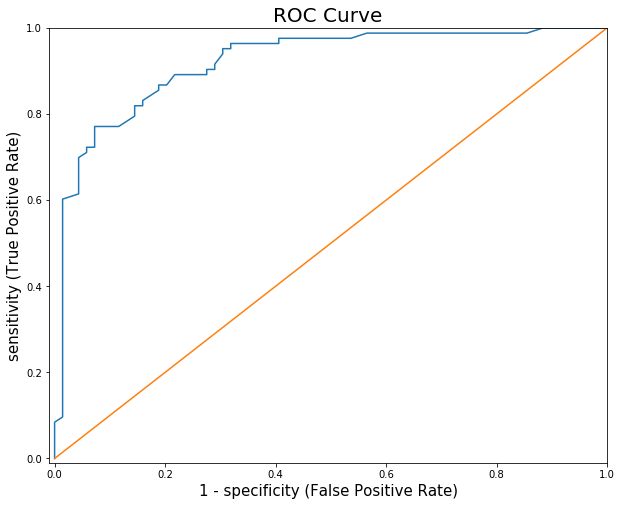

In [17]:
x_list = []
y_list = []

for x in np.linspace(0, 1, 100):
    
    # Same predictions based on predict_proba thresholds
    predicts = []
    
    for item in rf.predict_proba(X_test):
        if item[0] <= x:
            predicts.append(1)
        else:
            predicts.append(0)

    conf_matrix = pd.DataFrame(confusion_matrix(y_test, predicts), index = ['actual 0', 'actual 1'], 
                     columns = ['predicted 0', 'predicted 1'])
    
    
    # Assign TP, TN, FP, FN
    true_positives = conf_matrix['predicted 1'][1]
    true_negatives = conf_matrix['predicted 0'][0]
    false_positives = conf_matrix['predicted 1'][0]
    false_negatives = conf_matrix['predicted 0'][1]

    
    # Calculate Sensitivity and Specificity
    sensitivity = true_positives / (true_positives + false_negatives)

    specificity = true_negatives / (true_negatives + false_positives)
    
    
    # Append to lists to graph
    x_list.append(1 - specificity)

    y_list.append(sensitivity)

    
# Plot ROC curve

plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity (False Positive Rate)', fontsize = 15)
plt.ylabel('sensitivity (True Positive Rate)', fontsize = 15)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 1)
plt.plot(x_list, y_list);
plt.plot([0, 1], [0, 1]);

# x = 1 - specificity
# y = sensitivity

In [18]:
from sklearn.metrics import auc

In [19]:
auc(x_list, y_list)

0.9202025493277458

### Let's add associated costs to our TP, FP, TN, FN to our loop and minimize the cost
This is the naive way to optimize, but works well - you could also create a closed form optimization function

In [20]:
def cost_function(model, X_test, y_test, num_thres = 100, cost_fp = 3, cost_tn = 0.5, cost_tp = 1, cost_fn = 2):

    _thres = []; tpr = [] ; fpr = [] ; cost = []

    # assign model predictions
    prediction = model.predict_proba(X_test)

    ## Different code for same objective to calculate metrics at thresholds
    
    for thres in np.linspace(0.01, 1, num_thres):
        
        _thres.append(thres)
        predicts = np.zeros((prediction.shape[0], 1)) 
        predicts[np.where(prediction[:, 1] >= thres)] = 1

        conf_matrix = confusion_matrix(y_test, predicts)

        tp = conf_matrix[1, 1]
        tn = conf_matrix[0, 0]
        fp = conf_matrix[0, 1]
        fn = conf_matrix[1, 0]

        sensitivity = tp / (tp + fn)
        tnr = specificity = tn / (tn + fp)
        fnr = 1 - sensitivity

        tpr.append(sensitivity)
    
        fpr.append(1 - specificity)
        
        # add a cost function (this involves domain knowledge)
        
        current_cost = (cost_fp * fp) + (cost_tn * tn) + (cost_tp * tp) + (cost_fn * fn)
            
        cost.append(current_cost)  

    return fpr, tpr, cost, _thres

Text(0.3788405797101449, 0.933855421686747, 'Threshold:0.35')

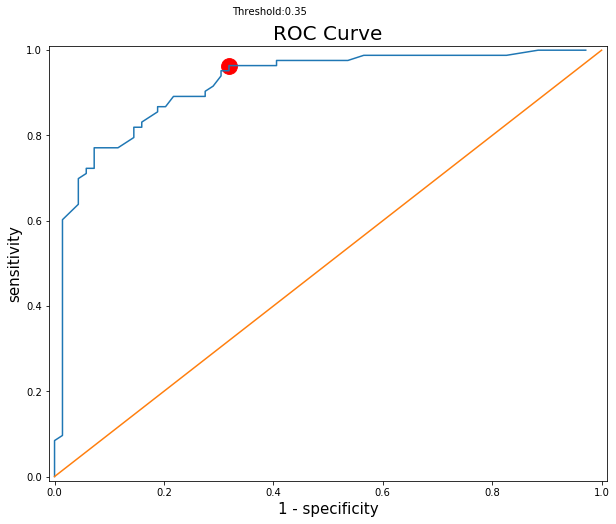

In [27]:
fpr, tpr, cost, thres = cost_function(model = rf, X_test = X_test, y_test = y_test,
                                      num_thres = 100, cost_fp = 2, cost_tn = 1, cost_tp = 1, cost_fn = 5)

cost_idx = np.argmin(cost)
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))

## Optimizing costs on multiple models

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [29]:
logreg = LogisticRegression(random_state=42)

In [30]:
logreg.fit(X_train, y_train)

/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
nb_class = GaussianNB()

In [32]:
nb_class.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
def cost_function_multi_model(model_list, X_test, y_test, num_thres = 100, cost_fp = 3, 
                              cost_tn = 0.5, cost_tp = 1, cost_fn = 2):
    '''model_list expects a list of already fit models - You could add the model.fit() code to the function.
    models in model_list MUST have the predict_proba() method - this could be modified in the future'''
    
    best_cost = []
    best_thresh = []
    
    for model in model_list:
        
        _thres = []
        cost = []

    # assign model predictions
        prediction = model.predict_proba(X_test)

    ## Different code for same objective to calculate metrics at thresholds
    
        for thres in np.linspace(0.01, 1, num_thres):

            _thres.append(thres)
            predicts = np.zeros((prediction.shape[0], 1)) 
            predicts[np.where(prediction[:, 1] >= thres)] = 1

            conf_matrix = confusion_matrix(y_test, predicts)

            tp = conf_matrix[1, 1]
            tn = conf_matrix[0, 0]
            fp = conf_matrix[0, 1]
            fn = conf_matrix[1, 0]

            # add a cost function (this involves domain knowledge)

            current_cost = (cost_fp * fp) + (cost_tn * tn) + (cost_tp * tp) + (cost_fn * fn)

            cost.append(current_cost)
        
        thresh_idx = np.array(cost).argmin()
        best_cost.append(min(cost))
        best_thresh.append(_thres[thresh_idx])

    return pd.DataFrame({'model':model_list, 'best_cost' : best_cost, 'best_thresh' : best_thresh})

In [34]:
cost_function_multi_model([rf, logreg, nb_class], X_test = X_test, y_test = y_test,
                         num_thres = 100, cost_fp = 3, cost_tn = 0.5, cost_tp = 1, cost_fn = 2)

,model,best_cost,best_thresh
0,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",149.0,0.57
1,"LogisticRegression(C=1.0, class_weight=None, d...",156.5,0.67
2,"GaussianNB(priors=None, var_smoothing=1e-09)",159.5,0.66


### Visualizing Threshold vs. Population Distribution

[ROC Curve Interactive Visualizer](http://www.navan.name/roc/)

In [35]:
import seaborn as sns

In [36]:
rf.predict_proba(X_test)[:5]

array([[0.19, 0.81],
       [0.21, 0.79],
       [0.44, 0.56],
       [0.08, 0.92],
       [0.66, 0.34]])

In [37]:
rf.predict(X_test)[:5]

array([1, 1, 1, 1, 0])

In [38]:
no_cancer_dist = []
cancer_dist = []

for item in rf.predict_proba(X_test):
    if item[0] <= .49:
        cancer_dist.append(item[0])
    else:
        no_cancer_dist.append(item[0])

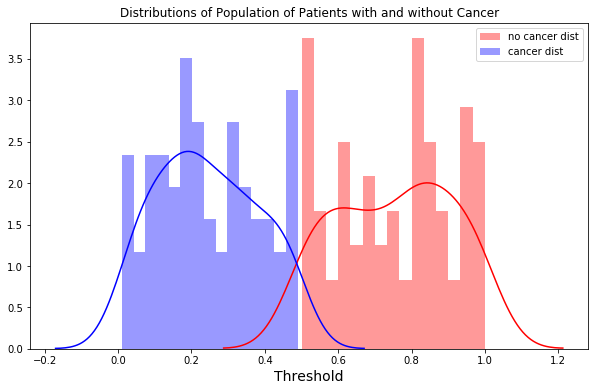

In [39]:
plt.figure(figsize = (10, 6))
plt.title('Distributions of Population of Patients with and without Cancer')
plt.xlabel('Threshold', fontsize = 14)

sns.distplot(no_cancer_dist, bins = 15, color = 'red')
sns.distplot(cancer_dist, bins = 15, color = 'blue')
plt.legend(['no cancer dist', 'cancer dist']);

### ROC curve vs Population Separation
![a](images/pop-curve.png)

![d](images/varying_dist_roc.png)

# Imbalanced Data

In [41]:
fraud_df = pd.read_csv('./data/creditcard.csv')

### Quick EDA

In [42]:
fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [43]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [44]:
fraud_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [45]:
fraud_df['Class'].value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [50]:
fraud_df[fraud_df['Amount'] == 0]['Class'].value_counts(normalize = True)

0    0.985205
1    0.014795
Name: Class, dtype: float64

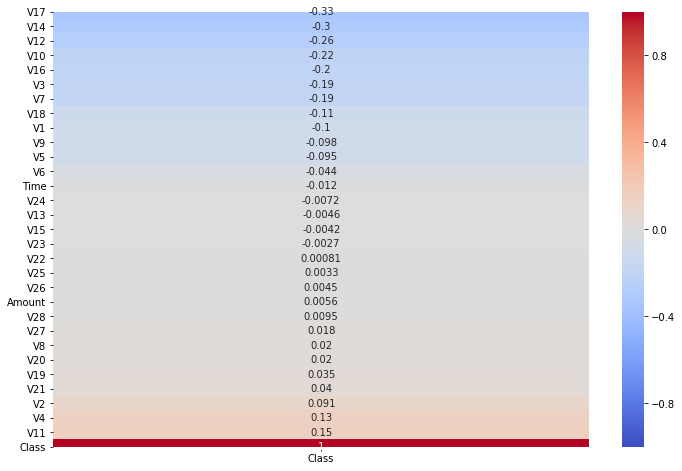

In [51]:
plt.figure(figsize = (12,8))
sns.heatmap(fraud_df.corr()[['Class']].sort_values(by = 'Class'), cmap = 'coolwarm', 
            vmin = -1, vmax = 1, annot = True);

In [46]:
fraud_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Assign X and y

In [52]:
X = fraud_df.loc[:, 'V26' : 'V27']

In [53]:
y = fraud_df['Class']

### Switch classes

In [ ]:
# y = 1 - y
# how to switch 0 and 1 labels

### Run model

In [54]:
fraud_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [56]:
fraud_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Results

In [57]:
fraud_rf.score(X_test, y_test) # good accuracy

0.9984270104772338

In [58]:
pd.DataFrame(confusion_matrix(y_test, fraud_rf.predict(X_test)), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])
# but terrible model

,predicted 0,predicted 1
actual 0,71077,2
actual 1,110,13


#### ROC Curve: Easy Method

In [59]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_recall_fscore_support

In [60]:
roc_curve(y_test, fraud_rf.predict_proba(X_test)[:, 1])

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.40688530e-05,
        1.40688530e-05, 1.40688530e-05, 1.40688530e-05, 1.40688530e-05,
        1.40688530e-05, 1.40688530e-05, 5.62754119e-05, 8.44131178e-05,
        9.84819708e-05, 1.12550824e-04, 1.40688530e-04, 1.68826236e-04,
        1.82895089e-04, 1.96963942e-04, 2.25101647e-04, 2.39170500e-04,
        2.67308206e-04, 2.95445912e-04, 3.37652471e-04, 3.51721324e-04,
        3.93927883e-04, 4.64272148e-04, 5.76822972e-04, 6.47167236e-04,
        7.03442648e-04, 7.73786913e-04, 8.58200031e-04, 1.08330168e-03,
        1.20992136e-03, 1.43502300e-03, 1.67419350e-03, 1.92743286e-03,
        2.11032794e-03, 2.41984271e-03, 2.84190830e-03, 3.13735421e-03,
        3.64383292e-03, 4.20658704e-03, 4.82561657e-03, 5.69788545e-03,
        6.68270516e-03, 7.79414454e-03, 9.63716428e-03, 1.16912168e-02,
        1.50114661e-02, 2.01043909e-02, 3.16408503e-02, 1.00000000e+00]),
 array([0.        , 0.01626016, 0.02439024, 0.02439024, 0.0406

In [61]:
fpr, tpr, threshold = roc_curve(y_test, fraud_rf.predict_proba(X_test)[:, 1])

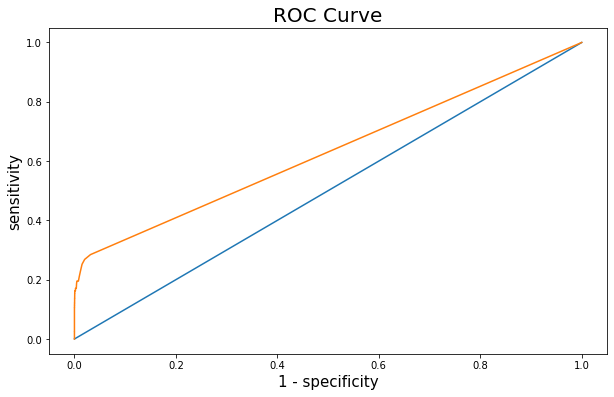

In [62]:
plt.figure(figsize = (10,6))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.plot([0,1], [0,1])
plt.plot(fpr,tpr);

In [63]:
auc(fpr,tpr)

0.6294710786132046

#### Precision Recall Curve

In [64]:
precision, recall, threshs = precision_recall_curve(y_test, fraud_rf.predict_proba(X_test)[:, 1])

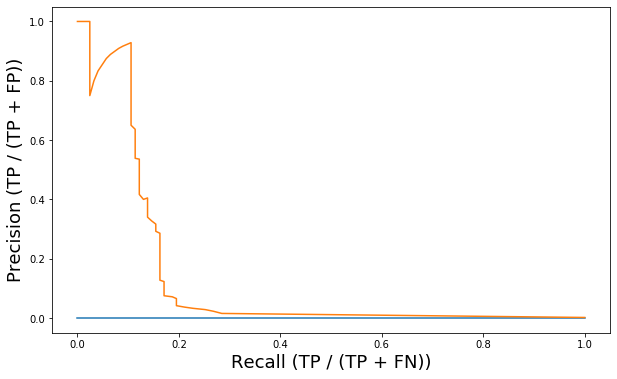

In [65]:
plt.figure(figsize = (10,6))
plt.xlabel('Recall (TP / (TP + FN))', fontsize = 18)
plt.ylabel('Precision (TP / (TP + FP))', fontsize = 18)
plt.plot([0,1], [0,0])
plt.plot(recall, precision);

**At ~0.2, not doing much better than random guessing**

### Using all columns

In [66]:
X = fraud_df.drop(columns=['Class', 'Time'])

In [67]:
y = fraud_df['Class']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [69]:
rf_fraud = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True)

In [70]:
rf_fraud.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

### Results

In [71]:
rf_fraud.oob_score_

0.9995178015495892

In [72]:
rf_fraud.score(X_test, y_test)

0.9995365298727564

In [73]:
fraud_preds = rf_fraud.predict(X_test)

In [74]:
pd.DataFrame(confusion_matrix(y_test, fraud_preds), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,71074,5
actual 1,28,95


In [75]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_recall_fscore_support

In [76]:
rf_fraud.predict_proba(X_test)[:, 1]

array([0., 0., 0., ..., 0., 0., 0.])

In [77]:
# roc_curve(y_test, rf_fraud.predict_proba(X_test)[:, 1])

In [78]:
fpr, tpr, threshold = roc_curve(y_test, rf_fraud.predict_proba(X_test)[:, 1])

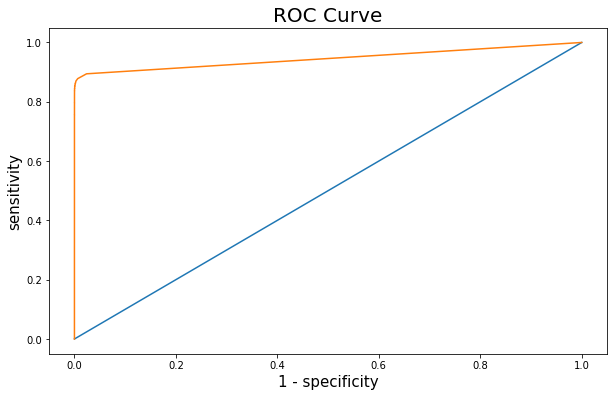

In [79]:
plt.figure(figsize = (10,6))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.plot([0,1], [0,1])
plt.plot(fpr,tpr);

In [80]:
auc(fpr, tpr)

0.9455507938779214

In [81]:
precision, recall, threshs = precision_recall_curve(y_test, rf_fraud.predict_proba(X_test)[:, 1])

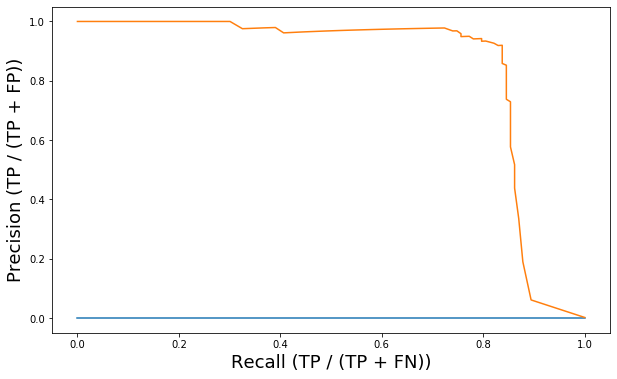

In [82]:
plt.figure(figsize = (10,6))
plt.xlabel('Recall (TP / (TP + FN))', fontsize = 18)
plt.ylabel('Precision (TP / (TP + FP))', fontsize = 18)
plt.plot([0,1], [0,0])
plt.plot(recall, precision);

### Try our cost function

In [ ]:
fpr, tpr, cost, thres = cost_function(model = rf_fraud, X_test = X_test, y_test = y_test,
                                      num_thres = 100, cost_fp = 1, cost_tn = 1, cost_tp = 1, cost_fn = 5)

cost_idx = np.argmin(cost)
min_cost_threshold = fpr[cost_idx], tpr[cost_idx], thres[cost_idx]

ax = plt.figure(figsize = (10, 8))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.xlim(-.01, 1.01)
plt.ylim(-.01, 1.01)
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1]);
plt.scatter(min_cost_threshold[0], min_cost_threshold[1], marker ='o', color = 'red', s=250)
ax.text(min_cost_threshold[0] + 0.06, min_cost_threshold[1] - 0.03, 'Threshold:'+ str(round(min_cost_threshold[2], 2)))

### SMOTE!

**Randomized search is usually better and faster than GridSearchCV**

In [83]:
from imblearn.over_sampling import SMOTE

/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [84]:
smote = SMOTE(k_neighbors=13)

In [85]:
X_train, y_train = smote.fit_sample(X_train, y_train)

/Users/flatironschooldc2/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [86]:
rf_smote = RandomForestClassifier(n_estimators=100, n_jobs=-1)

In [87]:
rf_smote.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [88]:
rf_smote.score(X_test,y_test)

0.9993960843796522

In [89]:
fraud_preds = rf_smote.predict(X_test)

In [90]:
pd.DataFrame(confusion_matrix(y_test, fraud_preds), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,71057,22
actual 1,21,102


In [91]:
fpr, tpr, threshold = roc_curve(y_test, rf_smote.predict_proba(X_test)[:, 1])

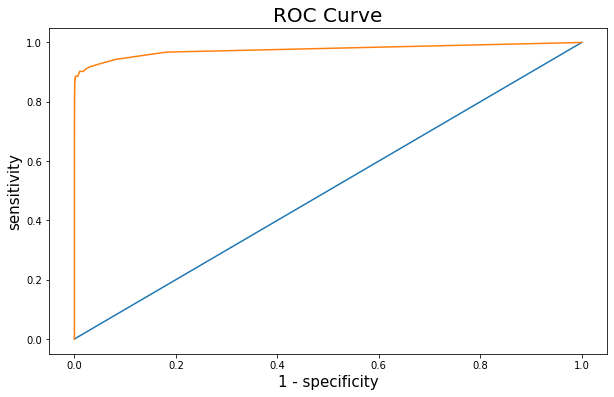

In [92]:
plt.figure(figsize = (10,6))
plt.title('ROC Curve', fontsize = 20)
plt.xlabel('1 - specificity', fontsize = 15)
plt.ylabel('sensitivity', fontsize = 15)
plt.plot([0,1], [0,1])
plt.plot(fpr,tpr);

In [93]:
auc(fpr, tpr)

0.9756353202328292

In [123]:
# manually adjust the threshold
predicts = []
for item in rf_smote.predict_proba(X_test):
    if item[0] <= .49:
        predicts.append(1)
    else:
        predicts.append(0)

In [124]:
pd.DataFrame(confusion_matrix(y_test, predicts), columns = ['predicted 0', 'predicted 1'], 
             index = ['actual 0', 'actual 1'])

,predicted 0,predicted 1
actual 0,71057,22
actual 1,21,102
